In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from statistics import mean
from statistics import stdev

from collections import Counter
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from ipywidgets import interactive, FloatSlider
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

In [2]:
# Plotting

def make_confusion_matrix(model, threshold=0.5):
    """
    Predict class1 if probability of being in class 1 is greater than threshold
    """
    y_predict = (model.predict_proba(features_test_scaled_array)[:, 1] >= threshold)
    confusion = confusion_matrix(target_test_ser, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap='YlGn', annot=True, square=True, fmt='d',
           xticklabels=['Rejected', 'Accepted'],
           yticklabels=['Rejected', 'Accepted']);
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)

In [3]:
# Import
physics_df = pd.read_csv('data/physics-ft-df.csv')
physics_df = physics_df.drop(columns = ["Unnamed: 0"])
print(physics_df.columns)

Index(['GPA', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing', 'GRE_Subject',
       'American', 'Papers', 'Research', 'Decision', 'GPA_rev',
       'GRE_Verbal_rev', 'GRE_Quantitative_rev', 'GRE_Writing_rev',
       'GRE_Subject_rev', 'Decision_rev', 'GPA_log', 'GRE_Verbal_log',
       'GRE_Quantitative_log', 'GRE_Writing_log', 'GRE_Subject_log', 'GPA_sq',
       'GRE_Verbal_sq', 'GRE_Quantitative_sq', 'GRE_Writing_sq',
       'GRE_Subject_sq', 'GRE_Verbal_pc', 'GRE_Quantitative_pc',
       'GRE_Writing_pc', 'GRE_Subject_pc', 'GREVxGREQ', 'GREVxGRES',
       'GREQxGRES', 'GREVxGREQxGRES'],
      dtype='object')


In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

In [5]:
# Set aside 20% of data for final test, should predict Decision, because we want to study effects of each
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(physics_df.drop(columns = ['Decision']), physics_df['Decision'], test_size=.2, random_state=42)

# Choose features
features_list = ['GPA', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing_pc', 'GRE_Subject', 'American', 'Papers', 'Research']
features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

In [6]:
rf_clf = RandomForestClassifier(random_state = 71)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.5966144542952062  +/-  0.023090780771368852
train_roc_auc_score:  0.6718169801459475  +/-  0.01979287456643385
test_f1_score =  0.5925925925925927
test_roc_auc_score =  0.6853624529505182
test_accuracy_score =  0.6292134831460674


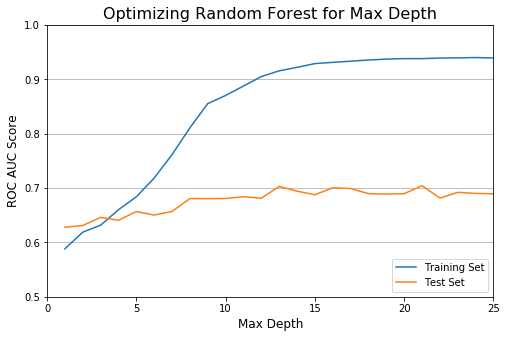

In [7]:
# Optimize max depth

max_depth_list = range(1, 26)
train_f1_score_list, train_roc_auc_score_list, train_accuracy_list = [], [], []
test_f1_score_list, test_roc_auc_score_list, test_accuracy_list = [], [], []

for i in max_depth_list:

    rf_clf = RandomForestClassifier(max_depth = i, random_state = 71)

    # Final train and test

    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
    features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
    features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

    rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

    train_f1_score_list.append(f1_score(rf_clf.predict(features_train_resampled_scaled_array), target_train_resampled_array))
    train_roc_auc_score_list.append(roc_auc_score(target_train_resampled_array, rf_clf.predict_proba(features_train_resampled_scaled_array)[:,1]))
    train_accuracy_list.append(accuracy_score(target_train_resampled_array, rf_clf.predict(features_train_resampled_scaled_array)))
    test_f1_score_list.append(f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
    test_roc_auc_score_list.append(roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
    test_accuracy_list.append(accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

# Plot results
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(max_depth_list, train_roc_auc_score_list, label = "Training Set")
plt.plot(max_depth_list, test_roc_auc_score_list, label = "Test Set")
ax.set_xlabel('Max Depth', fontsize=12)
ax.set_ylabel('ROC AUC Score', fontsize=12)
ax.set_xlim(left = 0, right = 25)
ax.set_ylim(bottom = 0.5, top = 1)
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.title('Optimizing Random Forest for Max Depth', fontsize=16);
plt.savefig("figures/max-depth.png", transparent=False, bbox_inches="tight")

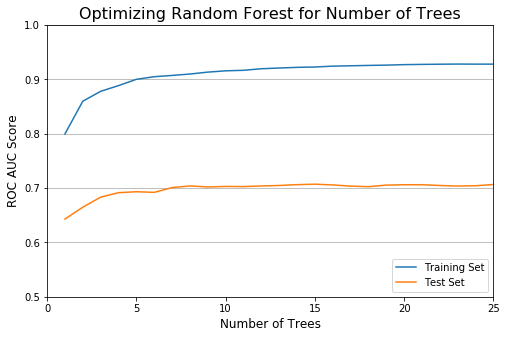

In [8]:
# Optimize number of trees

n_estimators_list = range(1, 30)
train_f1_score_list, train_roc_auc_score_list, train_accuracy_list = [], [], []
test_f1_score_list, test_roc_auc_score_list, test_accuracy_list = [], [], []

for i in n_estimators_list:

    rf_clf = RandomForestClassifier(n_estimators = i, max_depth = 13, random_state = 71)

    # Final train and test

    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
    features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
    features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

    rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

    train_f1_score_list.append(f1_score(rf_clf.predict(features_train_resampled_scaled_array), target_train_resampled_array))
    train_roc_auc_score_list.append(roc_auc_score(target_train_resampled_array, rf_clf.predict_proba(features_train_resampled_scaled_array)[:,1]))
    train_accuracy_list.append(accuracy_score(target_train_resampled_array, rf_clf.predict(features_train_resampled_scaled_array)))
    test_f1_score_list.append(f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
    test_roc_auc_score_list.append(roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
    test_accuracy_list.append(accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

# Plot results
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(n_estimators_list, train_roc_auc_score_list, label = "Training Set")
plt.plot(n_estimators_list, test_roc_auc_score_list, label = "Test Set")
ax.set_xlabel('Number of Trees', fontsize=12)
ax.set_ylabel('ROC AUC Score', fontsize=12)
ax.set_xlim(left = 0, right = 25)
ax.set_ylim(bottom = 0.5, top = 1)
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.title('Optimizing Random Forest for Number of Trees', fontsize=16);
plt.savefig("figures/number-of-trees.png", transparent=False, bbox_inches="tight")

In [9]:
rf_clf = RandomForestClassifier(max_depth = 13, n_estimators = 8, random_state = 71)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.6138743174726989  +/-  0.01471408576581624
train_roc_auc_score:  0.6641286096250937  +/-  0.016094033876368447
test_f1_score =  0.6441947565543071
test_roc_auc_score =  0.7039852943015418
test_accuracy_score =  0.6441947565543071


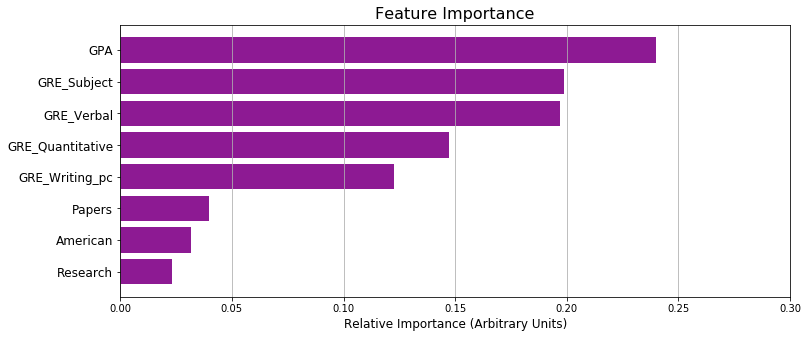

In [10]:
# Get feature importances

rf_important_features_list = list(zip(features_train_chosen_df.columns, rf_clf.feature_importances_))
rf_important_features_dict = dict(sorted(rf_important_features_list, key=lambda x: x[1], reverse = True))
features_list = list(rf_important_features_dict.keys())
importance_list = list(rf_important_features_dict.values())

y_pos = np.arange(len(features_list))

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(y_pos, importance_list[::-1], align='center', color = '#8d1a93', capsize=3)
ax.set_xlabel('Relative Importance (Arbitrary Units)', fontsize=12)
ax.set_xlim(left = 0, right = 0.3)
ax.set_yticks(y_pos)
ax.set_yticklabels(features_list[::-1], fontsize=12)
ax.set_title('Feature Importance', fontsize=16)
ax.xaxis.grid(True)
plt.savefig("figures/feature-importance.png", transparent=False, bbox_inches="tight")

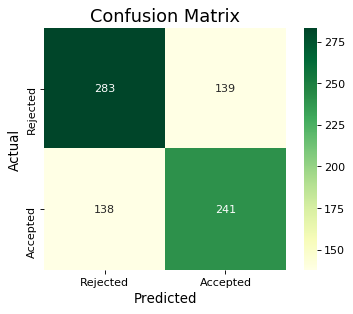

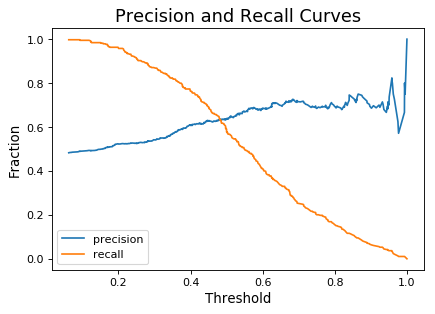

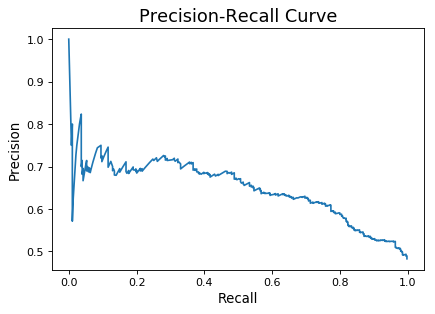

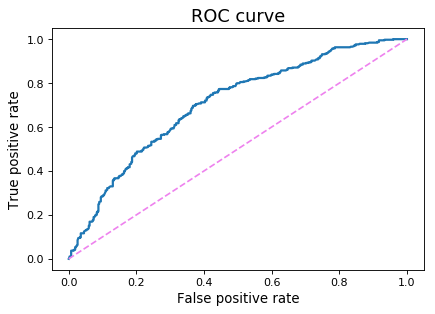

In [11]:
# Confusion Matrix
make_confusion_matrix(rf_clf, threshold = 0.481)
plt.savefig("figures/random-forest-optimized/confusion.png", transparent=True, bbox_inches="tight")

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.title('Precision and Recall Curves', fontsize=16)
plt.savefig("figures/random-forest-optimized/precision-and-recall.png", transparent=True, bbox_inches="tight")

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=16)
plt.savefig("figures/random-forest-optimized/precision-recall.png", transparent=True, bbox_inches="tight")

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC curve', fontsize=16)
plt.savefig("figures/random-forest-optimized/roc.png", transparent=True, bbox_inches="tight")